In [16]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
# and lets also prepare heatmap with dendogram
from string import ascii_letters

pd.options.plotting.backend = "plotly"

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [17]:
df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df2 = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col=['date'])

df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [18]:
df.info()
df2.plot()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


**Check missing values**

In [19]:
print(f"Number of missing values in ourt temperature column :{df.meantemp.isnull().sum()}")

Number of missing values in ourt temperature column :0


**Detect and remove outliers**


In [20]:
from scipy import stats

for column in df2.columns: 
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + 1.5*IQR
    lower_fence = Q1 - 1.5*IQR

    # Replace any values outside of Tukey's fences with NaN
    df2[column] = df2[column].where((df2[column] >= lower_fence) & (df2[column] <= upper_fence), np.nan)
df2.plot()

print("Lets see how many data is missing now in columns:")
nan_pct = df2.isna().sum() / len(df2) * 100
print(nan_pct)

Lets see how many data is missing now in columns:
meantemp        0.000000
humidity        0.136799
wind_speed      2.051984
meanpressure    0.615595
dtype: float64


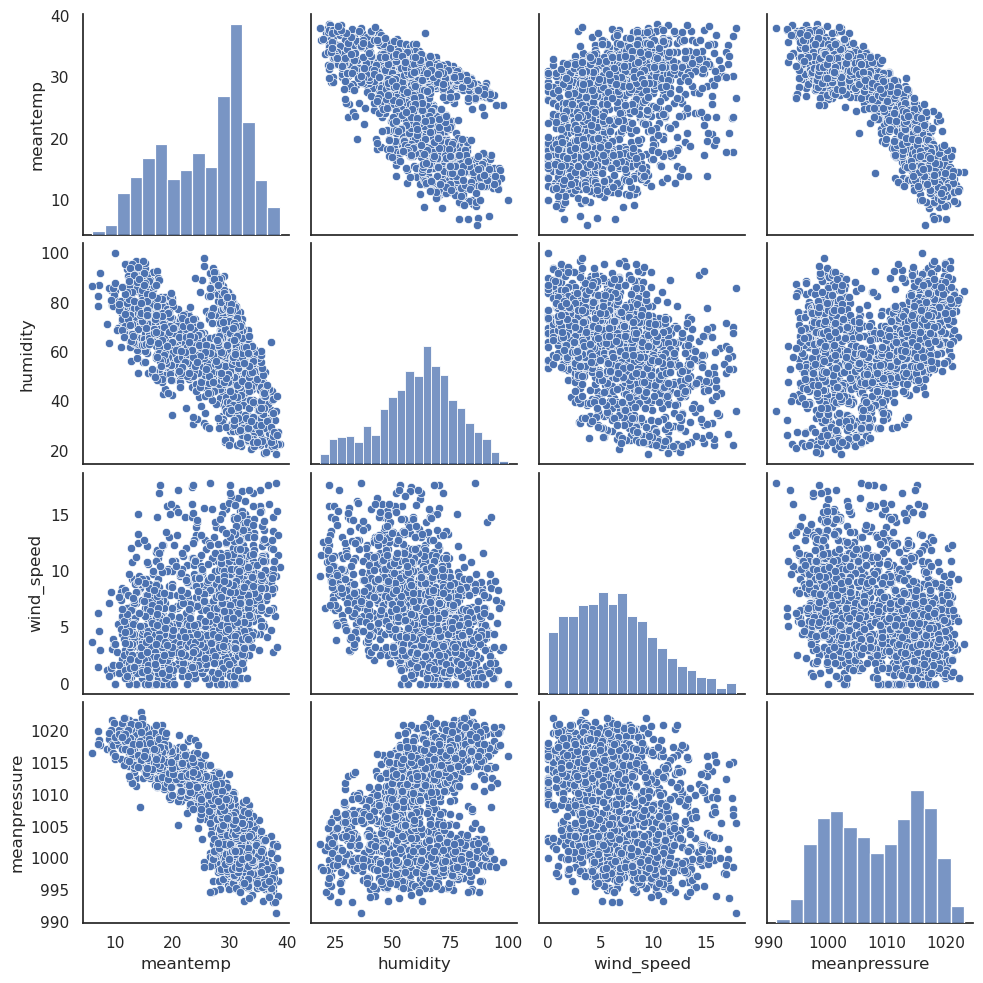

In [40]:
sns.pairplot(df2)

In [22]:
df_monthly = df2.resample('M').mean().interpolate()
fig = df_monthly.plot()
fig.show()

**Heatmap**

<Axes: >

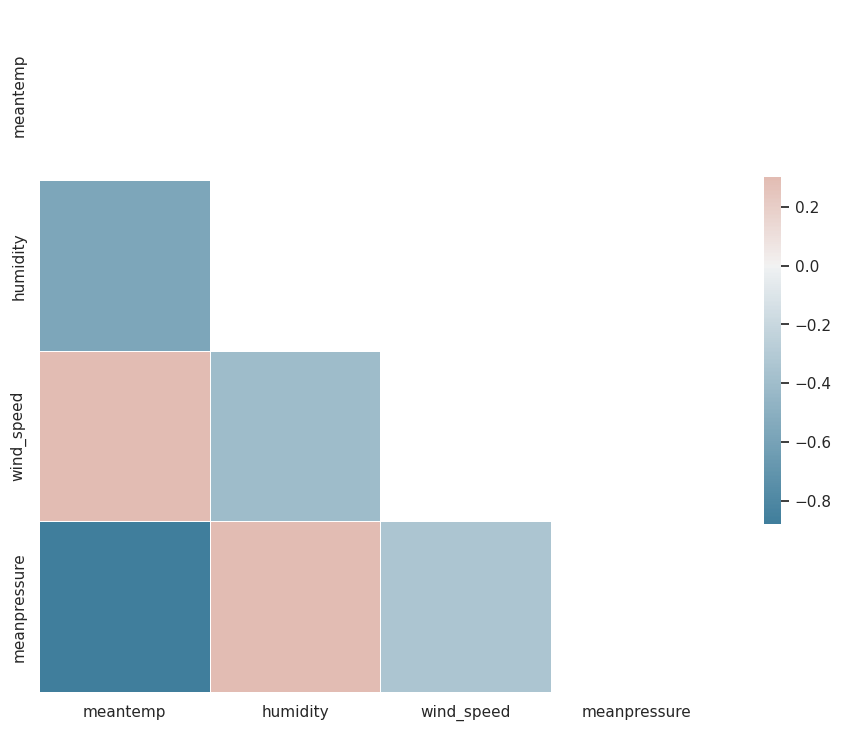

In [23]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = df2[["meantemp", "humidity", "wind_speed", "meanpressure"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
# Perform time series decomposition
for column in df2.columns:
    print("*__________________________*")
    print(f"Ploting Time Series Decomposition of column '{column}'")
    print("*__________________________*")
    decomp = seasonal_decompose(df2[column], model='additive')


    # Create DataFrame with decomposed components
    df_decomp = pd.DataFrame({
        'observed': decomp.observed.values,
        'trend': decomp.trend.values,
        'seasonal': decomp.seasonal.values,
        'resid': decomp.resid.values
    }, index=df2.index)
    fig = df_decomp.plot()
    fig.show()
    fig = df_decomp.groupby(df_decomp.index.month).sum().abs()["resid"].plot()
    fig.show()
    
    
    # Break because too much plots
    break

*__________________________*
Ploting Time Series Decomposition of column 'meantemp'
*__________________________*


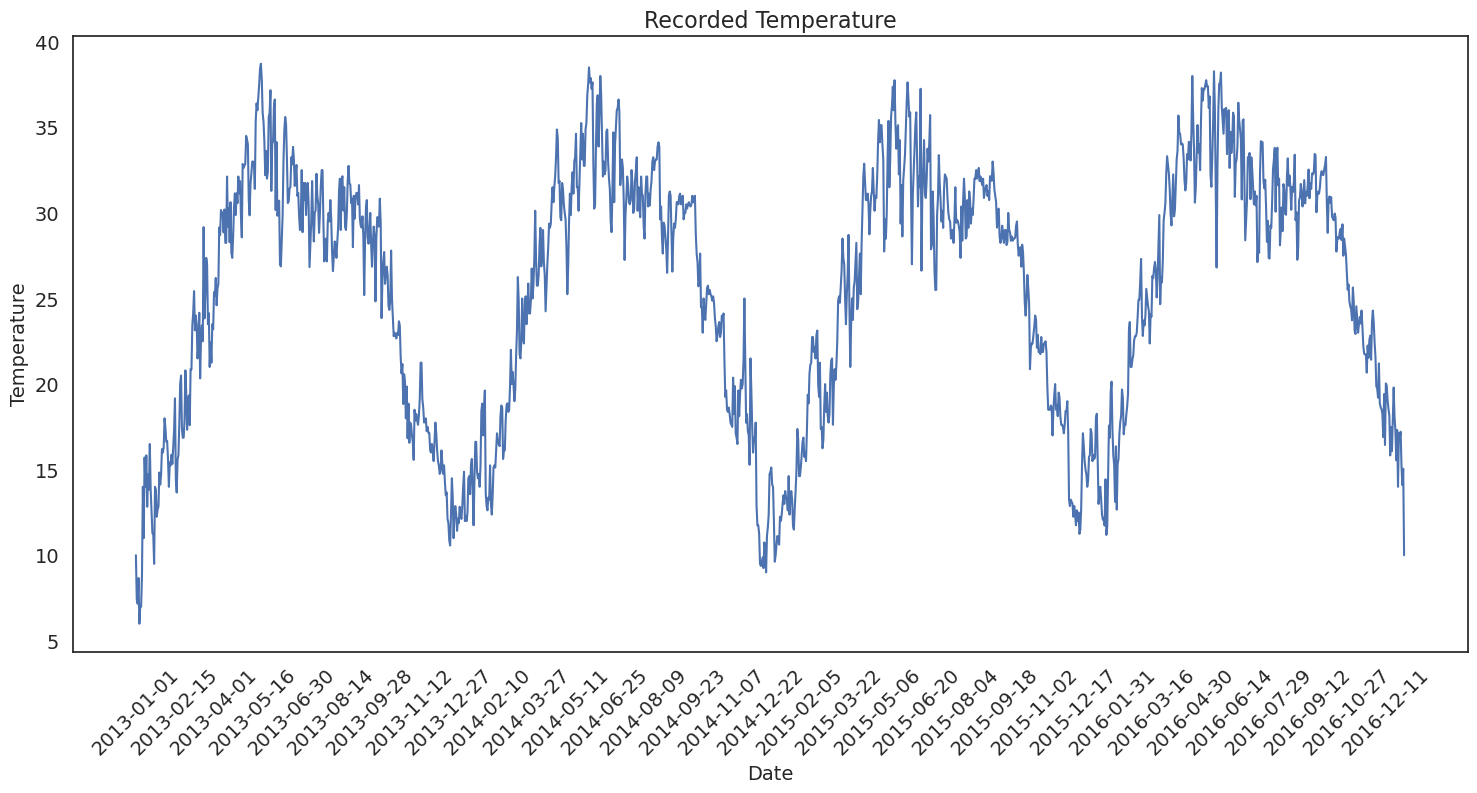

In [25]:
plt.figure(figsize=(18,8))
plt.plot(df.date, df['meantemp'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Recorded Temperature', fontsize=16)
plt.show()

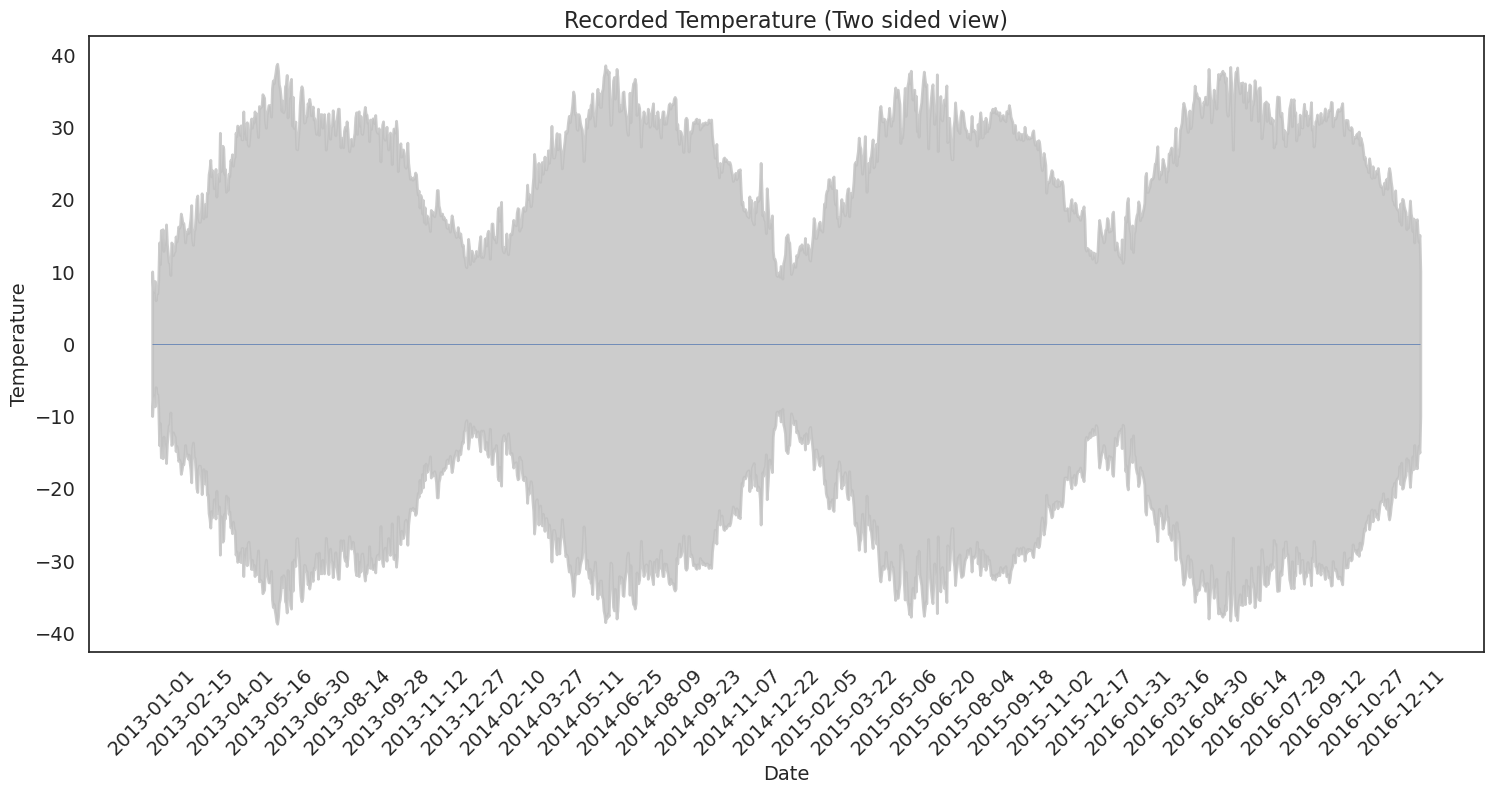

In [26]:
plt.figure(figsize=(18, 8))
plt.fill_between(df.date, y1=df['meantemp'], y2=-df['meantemp'], alpha=0.8, linewidth=2, color='silver')
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Recorded Temperature (Two sided view)", fontsize=16)
plt.show()


Temperature Years on Record:  2013 2014 2015 2016


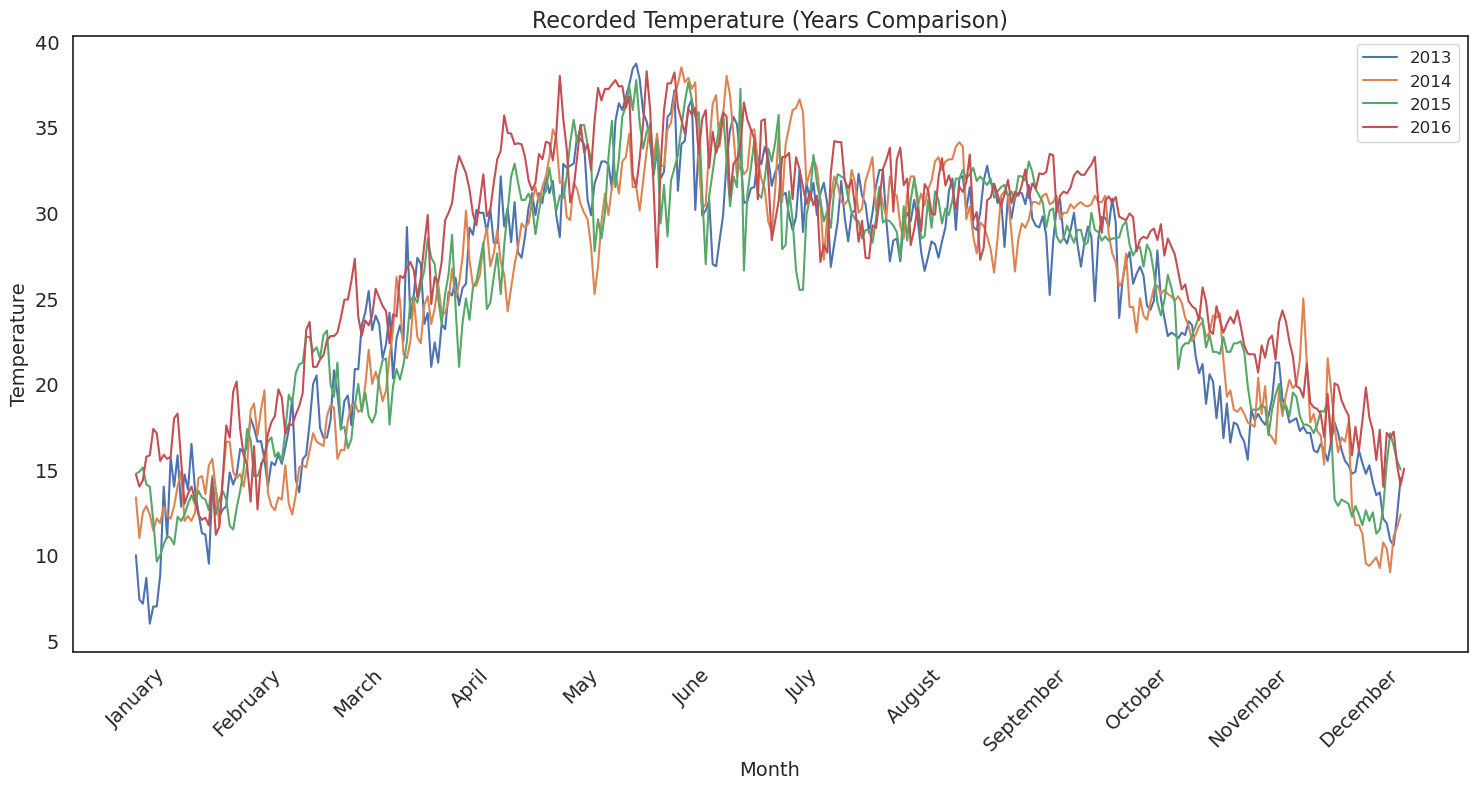

In [27]:
plt.figure(figsize=(18, 8))
dates = pd.to_datetime(df.date.iloc[:-1])
print("Temperature Years on Record: ", *dates.dt.year.unique())
for i in dates.dt.year.unique():
    plt.plot(df['meantemp'].iloc[:-1][dates.dt.year==i].values, label=i)
    
plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, 365, 32), labels=dates.dt.month_name().unique(), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Recorded Temperature (Years Comparison)", fontsize=16)
plt.legend(fontsize=12)
plt.show()

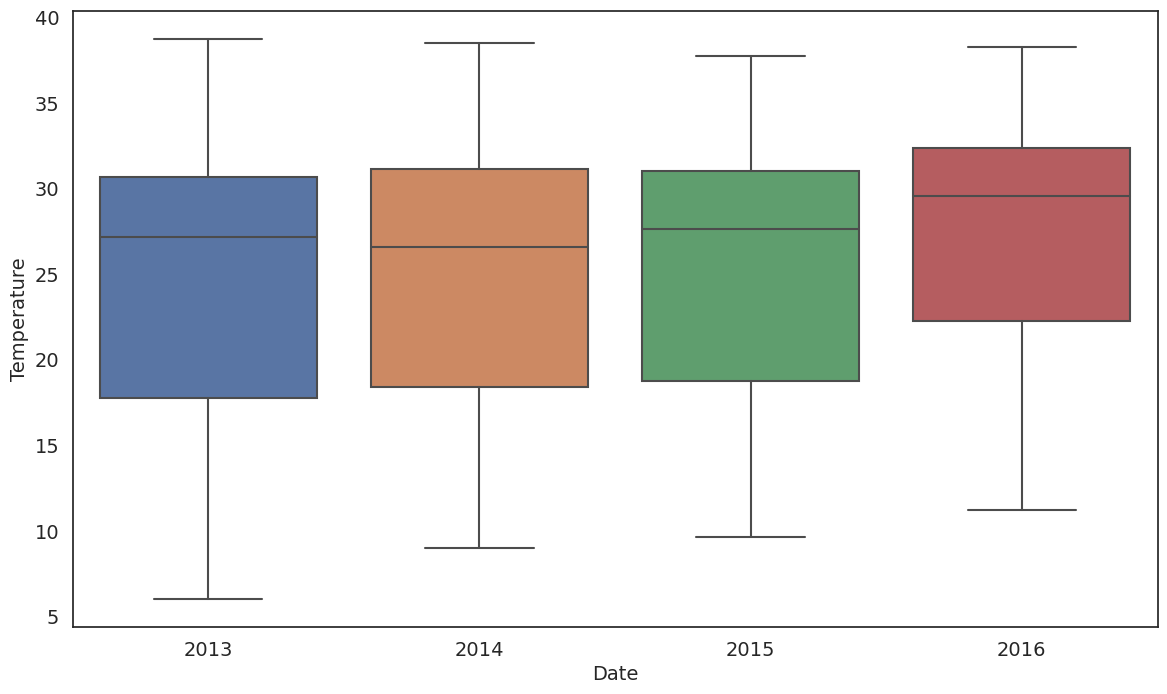

In [28]:
plt.figure(figsize=(14, 8))
sns.boxplot(x=dates.dt.year.iloc[:-1], y='meantemp', data=df.iloc[:-1])
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

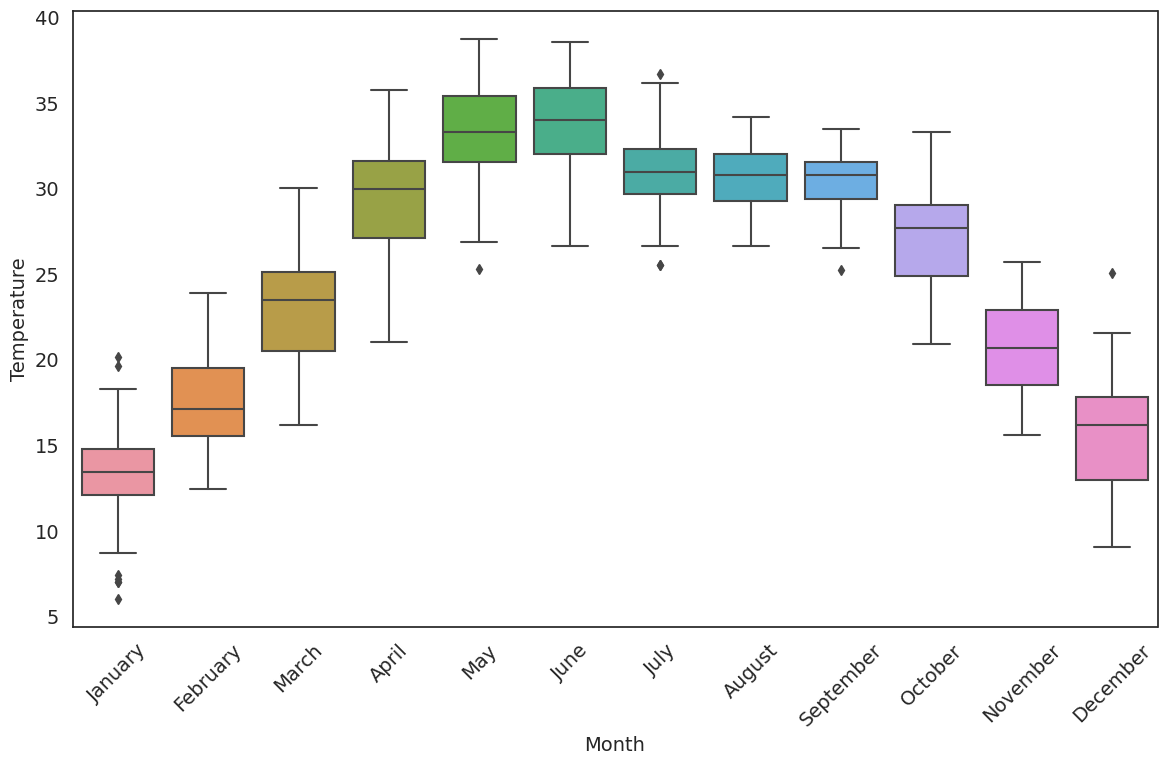

In [29]:
plt.figure(figsize=(14, 8))
sns.boxplot(x=dates.dt.month.iloc[:-1], y='meantemp', data=df.iloc[:-1])
plt.xlabel("Month", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, 12), labels=dates.dt.month_name().unique(), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

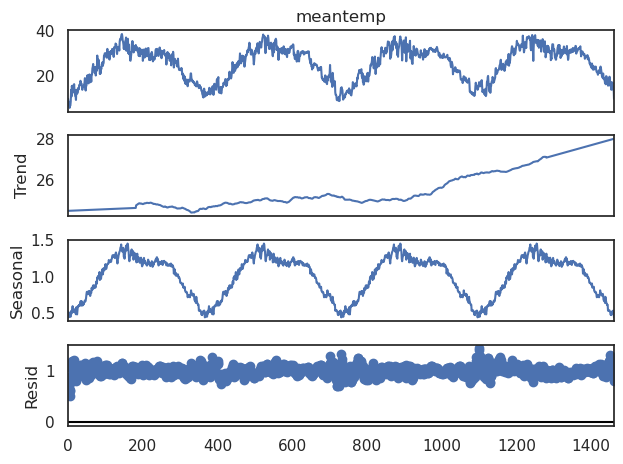

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
decomp_mul = seasonal_decompose(df['meantemp'], model='multiplicative', extrapolate_trend='freq', period=365)
decomp_mul.plot()
plt.show()

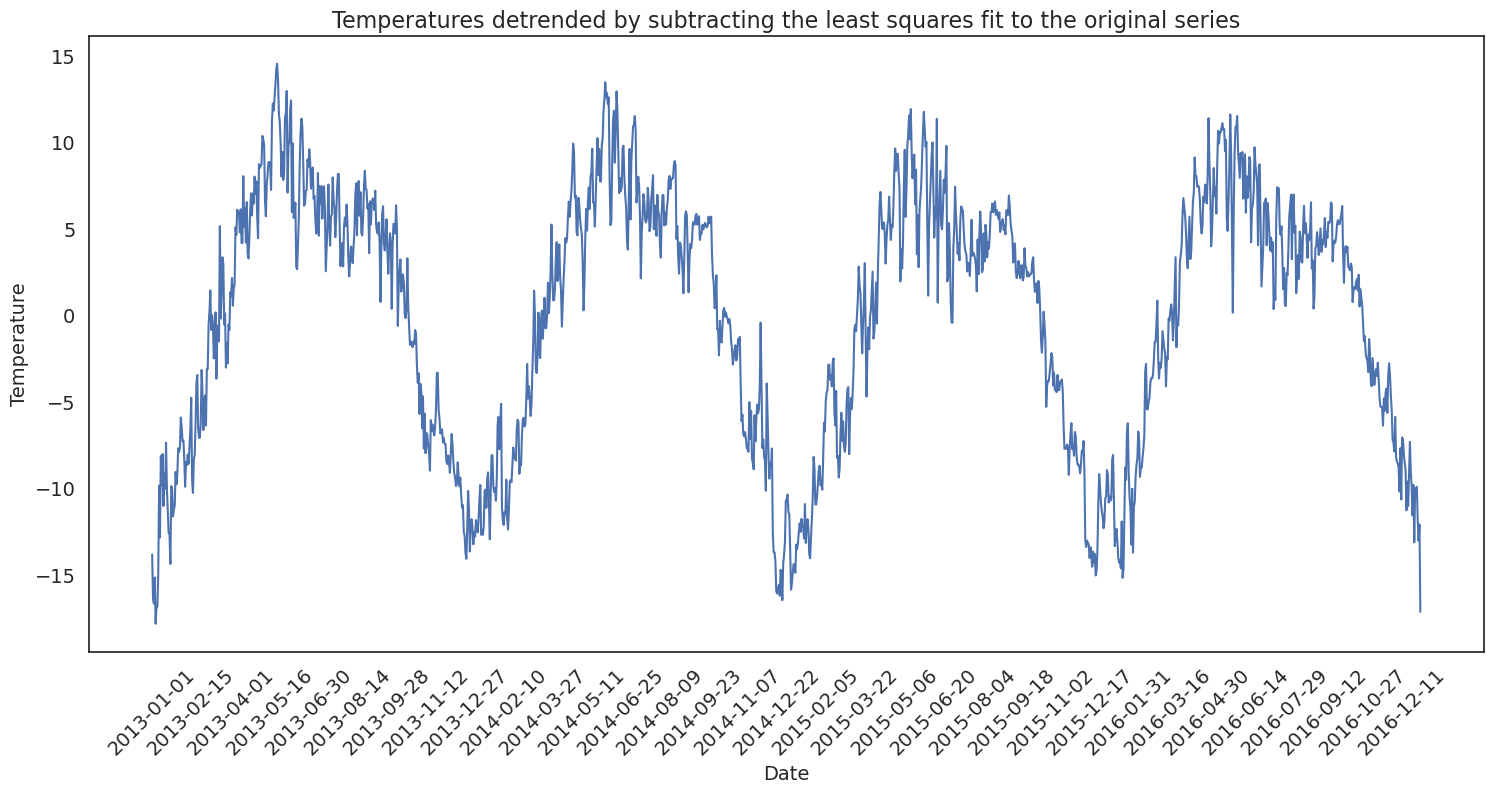

In [31]:
from scipy import signal

plt.figure(figsize=(18, 8))
detrended = signal.detrend(df['meantemp'].values)
plt.plot(df.date, detrended)
plt.title('Temperatures detrended by subtracting the least squares fit to the original series', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

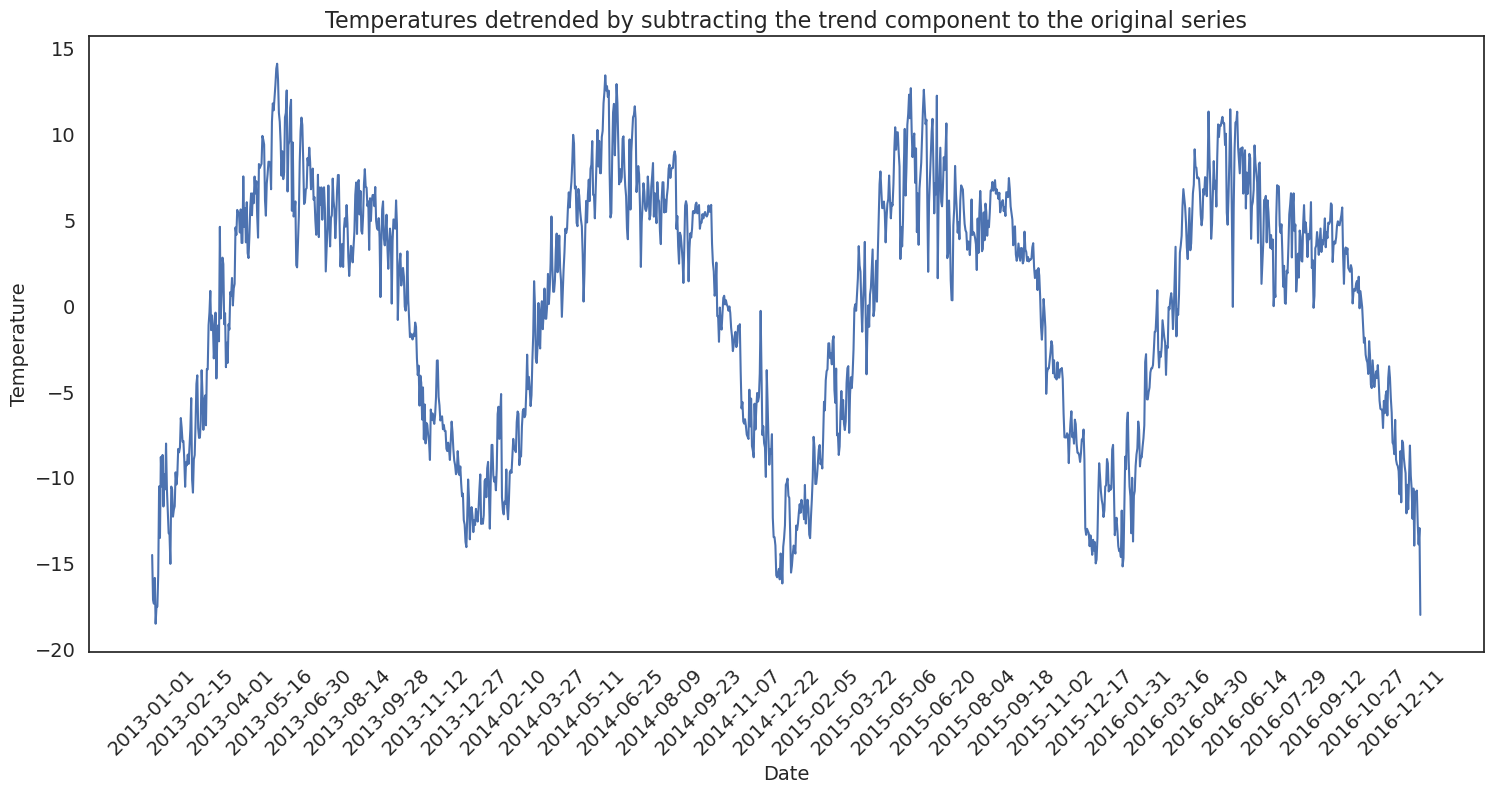

In [32]:
plt.figure(figsize=(18, 8))
decomp_mul = seasonal_decompose(df['meantemp'], model='multiplicative', extrapolate_trend='freq', period=365)
detrended = df['meantemp'].values - decomp_mul.trend
plt.plot(df.date, detrended)
plt.title('Temperatures detrended by subtracting the trend component to the original series', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

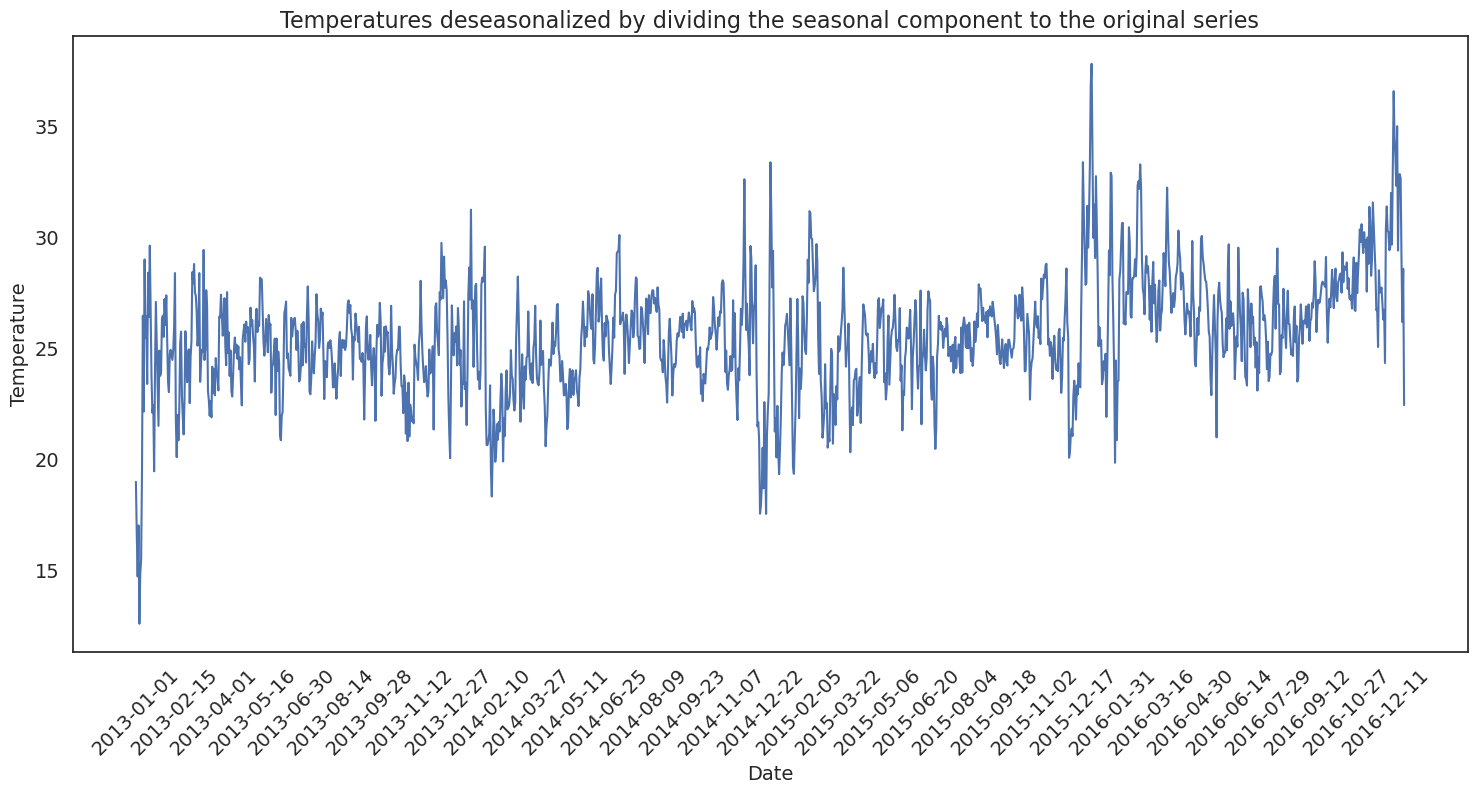

In [33]:
plt.figure(figsize=(18, 8))
deseasonalized = df['meantemp'].values / decomp_mul.seasonal
plt.plot(df.date, deseasonalized)
plt.title('Temperatures deseasonalized by dividing the seasonal component to the original series', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

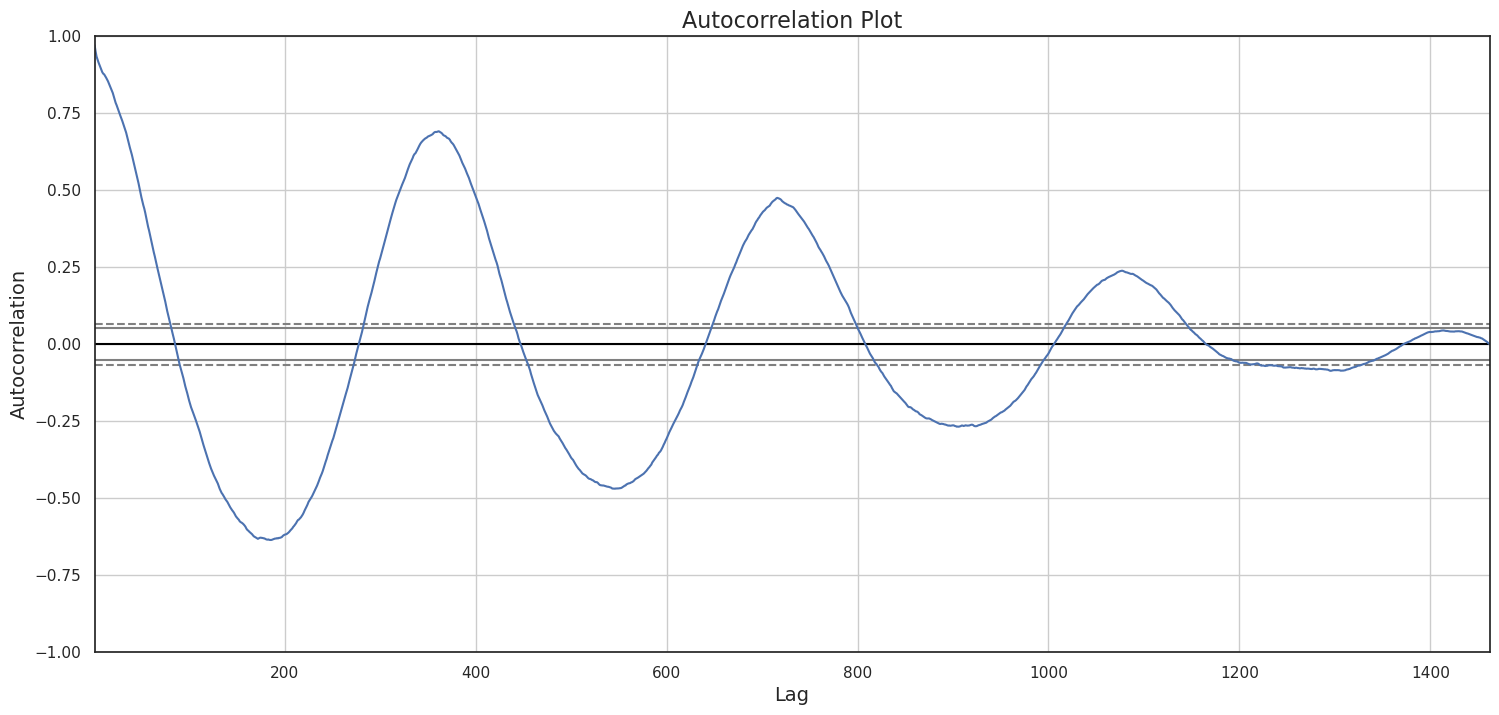

In [34]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(18, 8))
autocorrelation_plot(df['meantemp'])
plt.title('Autocorrelation Plot', fontsize=16)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.show()

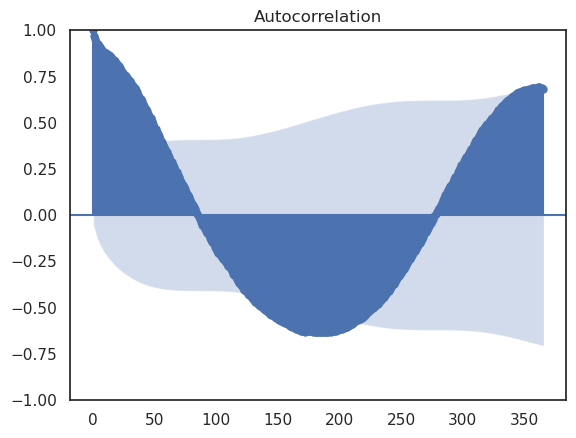

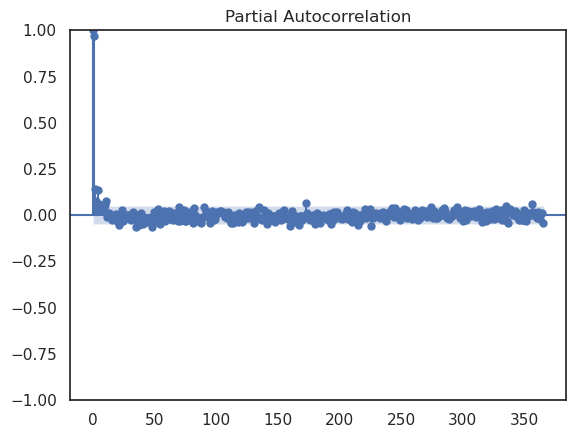

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['meantemp'], lags=365)
plt.show()
plot_pacf(df['meantemp'], lags=365)
plt.show()

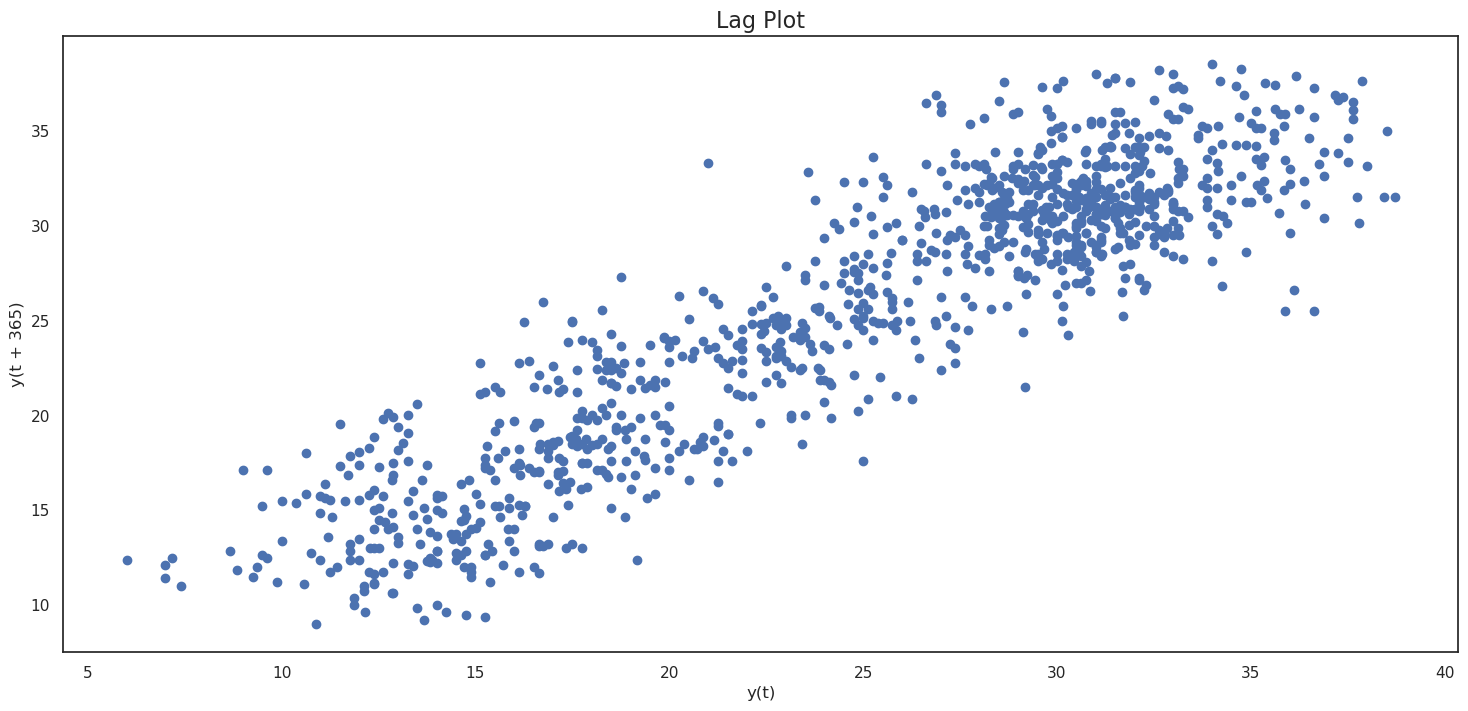

In [36]:
from pandas.plotting import lag_plot

plt.figure(figsize=(18, 8))
lag_plot(df['meantemp'], lag=365)
plt.title('Lag Plot', fontsize=16)
plt.show()

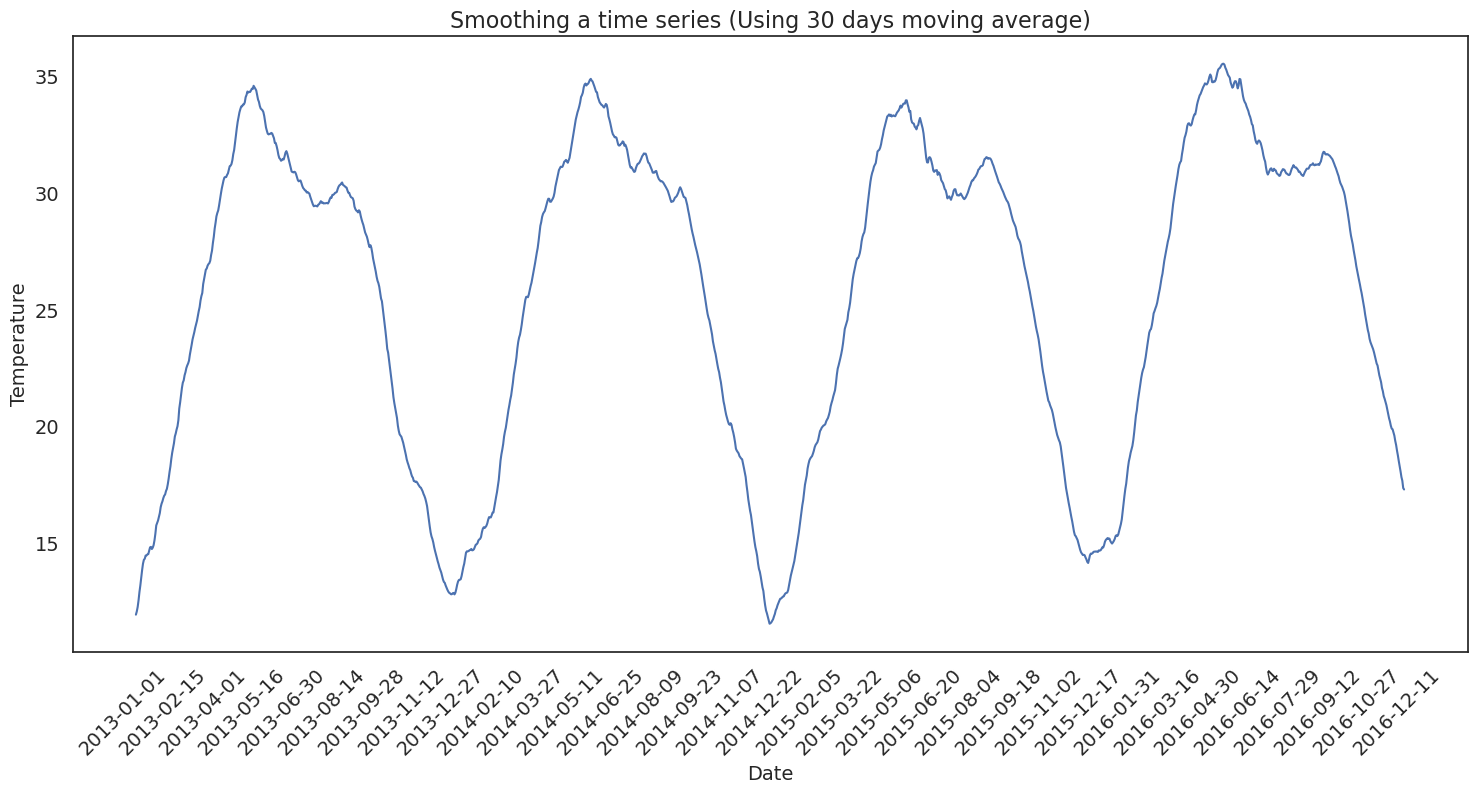

In [37]:
plt.figure(figsize=(18, 8))
df_ma = df['meantemp'].rolling(30, center=True, closed='both').mean()
plt.plot(df.date, df_ma)
plt.title('Smoothing a time series (Using 30 days moving average)', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [38]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS smoothing (Locally Weighted Regression)
df_loess = pd.DataFrame(lowess(df['meantemp'], np.arange(len(df['meantemp'])), frac=0.10)[:, 1], index=df.date, columns=['meantemp'])
df_loess.head()

,meantemp
date,
2013-01-01,9.021920
2013-01-02,9.206480
2013-01-03,9.391054
2013-01-04,9.575645
2013-01-05,9.760254


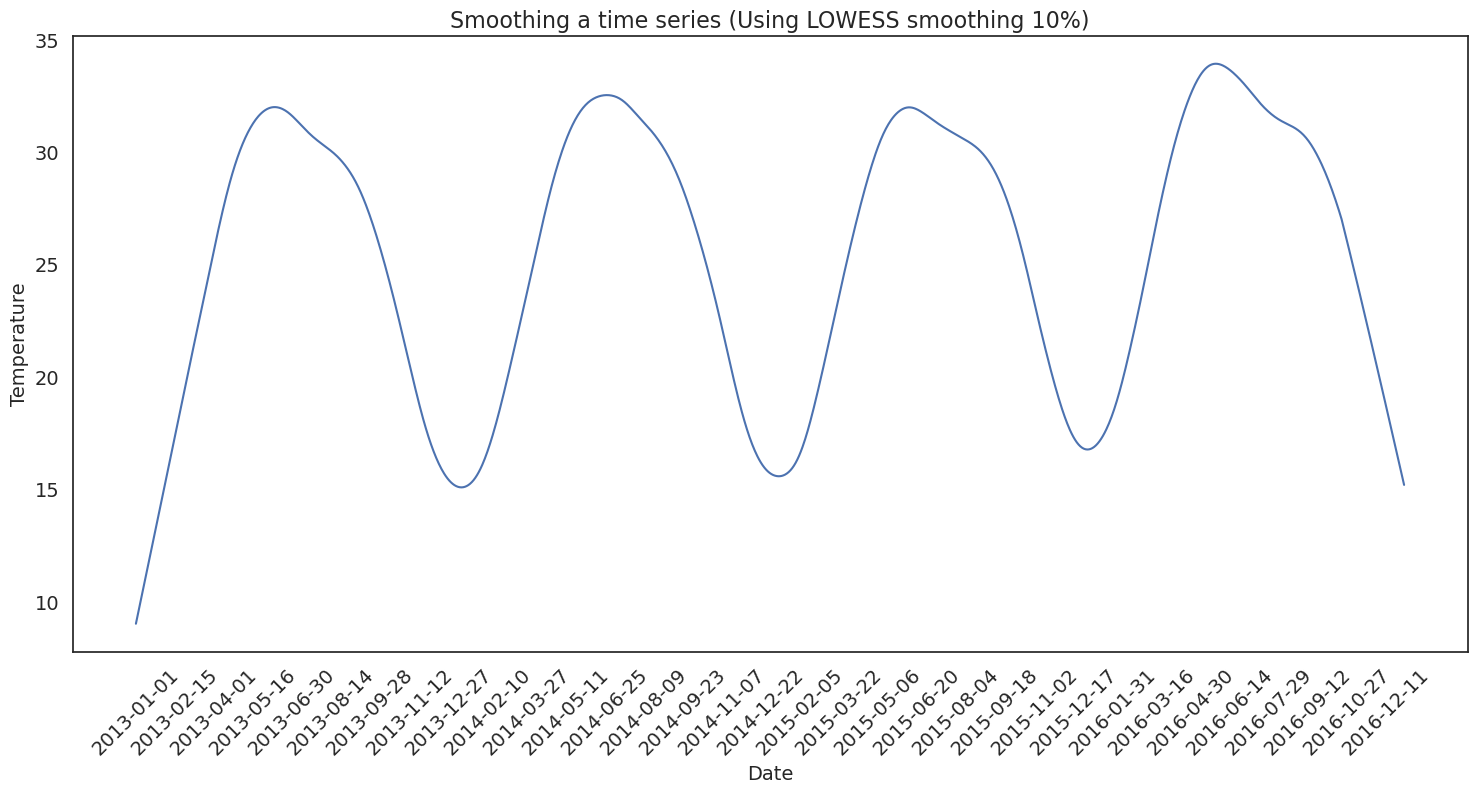

In [39]:
plt.figure(figsize=(18, 8))
plt.plot(df_loess.index, df_loess['meantemp'])
plt.title('Smoothing a time series (Using LOWESS smoothing 10%)', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.xticks(np.arange(0, len(df.date)+1, 45), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()